# Cockpit 이벤트 기반 IT 인프라 이상징후 유효성 판별

### [자연어 처리 순서]
1. 라이브러리 임포트
2. 파일 읽어오기
3. 특수문자 제거
4. 전처리
5. train data와 label data 분리
6. train set와 test set 분리
7. 전체 문장에 대해 단어 갯수, 단어 빈도 파악 하기 위해 Tokenizing 
8. 전체중에 희귀단어 건수 확인을 통해 max_words 확인
9. max_words 활용하여 다시 Tokenizing : fit_on_texts, texts_to_sequences
10. 전체 문장에서 최적 Max Len를 찾아보자
11. Padding Sequence : Max Len 사용
12. Modeling

### 라이브러리 임포트

In [1]:
import numpy as np
import pandas as pd

In [2]:
#AIDU 내부 연동을 위한 라이브러리
from aicentro.session import Session
from aicentro.framework.keras import Keras as AiduFrm

# AIDU와 연동을 위한 변수
aidu_session = Session(verify=False)
aidu_framework = AiduFrm(session=aidu_session)

### 파일 읽어오기

In [3]:
# 이벤트 분류를 위한 기본 사전(한글, 영문)
_dict_df = pd.read_csv(aidu_framework.config.data_dir + '/event_classification_dictionary.csv')

In [4]:
# 레이블
_label_dict_df = pd.read_csv(aidu_framework.config.data_dir + '/event_classification_dictionary1.csv', names=['kor','eng'])

In [5]:
# Training Data
DATA_PATH = aidu_framework.config.data_dir + '/cockpit_data_2019-01-21.csv'
data = pd.read_csv(DATA_PATH, header=None, names=['a','b','c','d','e','f','g','h','i','avail']).dropna()

In [6]:
data

,a,b,c,d,e,f,g,h,i,avail
0,Fatal,서버,[*선릉(SDSC)*]/data 디스크 남은 용량 : 9.66 %,서비스플랫폼,GPS측위,2017-10-31 23:50:27+09,NEW_SLP01,OS,OS0009,조치
1,Critical,서버,[ITO]Oct 31 21:31:45 nbilns30 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:33:24+09,nbilns30,기타,nbilns30__OS_Log__OS__file system full,조치
2,Critical,서버,[ITO]Oct 31 21:25:55 nbilns40 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:26:21+09,nbilns40,기타,nbilns40__OS_Log__OS__file system full,조치
3,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:16:03+09,BD-L3-MIDASGW01,AP,jboss 프로세스(midas-mcard),조치
4,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:14:05+09,BD-L3-MIDASGW02,AP,jboss 프로세스(midas-mcard),조치
...,...,...,...,...,...,...,...,...,...,...
66486,Fatal,서버,[*선릉(SDSC)*]IAMUI42 Process DOWN,인증플랫폼,IAMUI,2018-07-04 03:33:24+09,BD-L2-IAMUIWAS04,MW,MW,작업관련
66487,Fatal,서버,[*선릉(SDSC)*]Apche http Port Down,인증플랫폼,IAMUI,2018-07-04 00:17:25+09,BD-L2-IAMUIWEB01,MW,MW,작업관련
66488,Critical,보안장비,[*Legacy_NMS*]SYSLOG,Shared Service (보안),침입차단,2018-07-03 01:35:34+09,GC_Neoss_fw1,기타,SYSLOG,작업관련
66489,Critical,서버,[*선릉(SDSC)2*]10001 port Down,서비스플랫폼,GIS플랫폼,2018-07-02 18:33:35+09,GIS-RP-PEDESTRIAN02,AP,GIS B2BNAVI_RESTAPI_10001 port 감시(서비스),작업관련


In [7]:
data.to_csv(aidu_framework.config.data_dir + '/cockpit_data_conv_2019-01-21.csv')
data = pd.read_csv(aidu_framework.config.data_dir + '/cockpit_data_conv_2019-01-21.csv')

In [8]:
# 데이터 확인
_dict_df.head()

,클라이언트에서 요청한 사용자의 약관동의 정보 없음,No information on client's agreement to the terms requested
0,국가정보통신서비스인프라관리,National Information and Communication Service...
1,멤버십 롯데영카드 통신오류 또는 데이터없음,Membership Lotte Young Card Communication erro...
2,멤버십 클럽 아티제 통신오류 또는 데이터없음,Membership Club Artifact No communication erro...
3,클라이언트에서 요청한 사용자의 약관동,Terms of agreement for the user requested by t...
4,멤버십 전체 오류 통신오류 또는 데이터없음,Membership full error Communication error or n...


In [9]:
_label_dict_df.head()

,kor,eng
0,작업 관련,Work related
1,작업관련,Work related
2,무조치,No action
3,조치,measure


In [10]:
data.head()

,Unnamed: 0,a,b,c,d,e,f,g,h,i,avail
0,0,Fatal,서버,[*선릉(SDSC)*]/data 디스크 남은 용량 : 9.66 %,서비스플랫폼,GPS측위,2017-10-31 23:50:27+09,NEW_SLP01,OS,OS0009,조치
1,1,Critical,서버,[ITO]Oct 31 21:31:45 nbilns30 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:33:24+09,nbilns30,기타,nbilns30__OS_Log__OS__file system full,조치
2,2,Critical,서버,[ITO]Oct 31 21:25:55 nbilns40 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:26:21+09,nbilns40,기타,nbilns40__OS_Log__OS__file system full,조치
3,3,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:16:03+09,BD-L3-MIDASGW01,AP,jboss 프로세스(midas-mcard),조치
4,4,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:14:05+09,BD-L3-MIDASGW02,AP,jboss 프로세스(midas-mcard),조치


In [11]:
data.describe()

,Unnamed: 0
count,66083.000000
mean,33334.255209
std,19196.723361
min,0.000000
25%,16757.500000
50%,33412.000000
75%,49956.500000
max,66490.000000


### Label 분포 확인

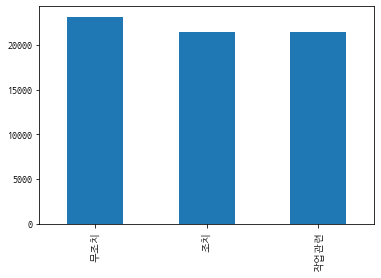

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

data['avail'].value_counts().plot(kind='bar')

### 컬럼을 합쳐 하나의 텍스트로 변환 

In [13]:
def convert_dataset(df):
    df['text'] = df['a'] + df['b'] + df['c'] + df['d'] + df['e'] + df['f'].str.slice(11,13) + df['g'] + df['h'] + df['i'] 
    return df

In [14]:
df = convert_dataset(data)

In [15]:
df

,Unnamed: 0,a,b,c,d,e,f,g,h,i,avail,text
0,0,Fatal,서버,[*선릉(SDSC)*]/data 디스크 남은 용량 : 9.66 %,서비스플랫폼,GPS측위,2017-10-31 23:50:27+09,NEW_SLP01,OS,OS0009,조치,Fatal서버[*선릉(SDSC)*]/data 디스크 남은 용량 : 9.66 %서비스...
1,1,Critical,서버,[ITO]Oct 31 21:31:45 nbilns30 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:33:24+09,nbilns30,기타,nbilns30__OS_Log__OS__file system full,조치,Critical서버[ITO]Oct 31 21:31:45 nbilns30 vmunix...
2,2,Critical,서버,[ITO]Oct 31 21:25:55 nbilns40 vmunix: msgcnt 1...,유선 BSS,ICIS요금민원,2017-10-31 21:26:21+09,nbilns40,기타,nbilns40__OS_Log__OS__file system full,조치,Critical서버[ITO]Oct 31 21:25:55 nbilns40 vmunix...
3,3,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:16:03+09,BD-L3-MIDASGW01,AP,jboss 프로세스(midas-mcard),조치,Fatal서버[*선릉(SDSC)*]Jboss(midas-mcard) Processe...
4,4,Fatal,서버,[*선릉(SDSC)*]Jboss(midas-mcard) Processess Down,서비스플랫폼,마케팅인사이트플랫폼,2017-10-31 21:14:05+09,BD-L3-MIDASGW02,AP,jboss 프로세스(midas-mcard),조치,Fatal서버[*선릉(SDSC)*]Jboss(midas-mcard) Processe...
...,...,...,...,...,...,...,...,...,...,...,...,...
66078,66486,Fatal,서버,[*선릉(SDSC)*]IAMUI42 Process DOWN,인증플랫폼,IAMUI,2018-07-04 03:33:24+09,BD-L2-IAMUIWAS04,MW,MW,작업관련,Fatal서버[*선릉(SDSC)*]IAMUI42 Process DOWN인증플랫폼IA...
66079,66487,Fatal,서버,[*선릉(SDSC)*]Apche http Port Down,인증플랫폼,IAMUI,2018-07-04 00:17:25+09,BD-L2-IAMUIWEB01,MW,MW,작업관련,Fatal서버[*선릉(SDSC)*]Apche http Port Down인증플랫폼IA...
66080,66488,Critical,보안장비,[*Legacy_NMS*]SYSLOG,Shared Service (보안),침입차단,2018-07-03 01:35:34+09,GC_Neoss_fw1,기타,SYSLOG,작업관련,Critical보안장비[*Legacy_NMS*]SYSLOGShared Service...
66081,66489,Critical,서버,[*선릉(SDSC)2*]10001 port Down,서비스플랫폼,GIS플랫폼,2018-07-02 18:33:35+09,GIS-RP-PEDESTRIAN02,AP,GIS B2BNAVI_RESTAPI_10001 port 감시(서비스),작업관련,Critical서버[*선릉(SDSC)2*]10001 port Down서비스플랫폼GI...


### 한글을 영문으로 변환

In [16]:
def get_en_kr_converted(dict_data, list_data):
    for kor, eng in dict_data.values:
        list_data = list_data.replace(kor, " " + eng + " ")
    return list_data

In [17]:
features_data = []
row_idx = 0

for line in df['text']:
    features_data.append(get_en_kr_converted(_dict_df, line.strip()))
    row_idx += 1

In [18]:
features_data[:3]

['Fatal server [* Seolleung (SDSC)*]/data  Disk remaining capacity  : 9.66 % Service platform  GPS positioning 23NEW_SLP01OSOS0009',
 'Critical server [ITO]Oct 31 21:31:45 nbilns30 vmunix: msgcnt 11 vxfs: mesg 001: vx_nospace - /dev/vg01/lvol4 file systemfull (1 block extent) cable  BSSICIS Rate of complaints 21nbilns30 Etc nbilns30__OS_Log__OS__file system full',
 'Critical server [ITO]Oct 31 21:25:55 nbilns40 vmunix: msgcnt 11 vxfs: mesg 001: vx_nospace - /dev/vg01/lvol4 file systemfull (1 block extent) cable  BSSICIS Rate of complaints 21nbilns40 Etc nbilns40__OS_Log__OS__file system full']

### 특수문자 제거

In [19]:
# [] :  % / () * - 특수문자 공백으로 치완
import re
pattern = re.compile(r'[\[\]:%/()*-]')

In [20]:
features_data1 = []
for line in features_data:
    line = re.sub(r'\w+ [0-9]+ [0-9]+:[0-9]+:[0-9]+ ',' ',line)
    line = pattern.sub(' ',line)
    line = re.sub(r' +',' ', line)
    features_data1.append(line)

In [21]:
features_data1[:3]

['Fatal server Seolleung SDSC data Disk remaining capacity 9.66 Service platform GPS positioning 23NEW_SLP01OSOS0009',
 'Critical server ITO nbilns30 vmunix msgcnt 11 vxfs mesg 001 vx_nospace dev vg01 lvol4 file systemfull 1 block extent cable BSSICIS Rate of complaints 21nbilns30 Etc nbilns30__OS_Log__OS__file system full',
 'Critical server ITO nbilns40 vmunix msgcnt 11 vxfs mesg 001 vx_nospace dev vg01 lvol4 file systemfull 1 block extent cable BSSICIS Rate of complaints 21nbilns40 Etc nbilns40__OS_Log__OS__file system full']

### Label 데이터도 영문으로 변환

In [22]:
labels_data = []
row_idx = 0

for line in df['avail']:
    labels_data.append(get_en_kr_converted(_label_dict_df, line.strip()))
    row_idx += 1

In [23]:
# 앞뒤에 공백 포함 주의
labels_data[:3]

[' measure ', ' measure ', ' measure ']

### 변환된 데이터 저장

In [24]:
row_data = {'en_text': features_data1, 'en_label': labels_data}
final_data = pd.DataFrame(row_data)

In [25]:
final_data.to_csv(aidu_framework.config.data_dir + '/cockpit_data_conv_final_2019-01-21.csv')

In [26]:
final_data.head()

,en_text,en_label
0,Fatal server Seolleung SDSC data Disk remainin...,measure
1,Critical server ITO nbilns30 vmunix msgcnt 11 ...,measure
2,Critical server ITO nbilns40 vmunix msgcnt 11 ...,measure
3,Fatal server Seolleung SDSC Jboss midas mcard ...,measure
4,Fatal server Seolleung SDSC Jboss midas mcard ...,measure


### label 숫자로 인코딩

In [27]:
label2class = {' Work related ':0, ' measure ':1 , ' No action ':2}
class2label = {0:' Work related ', 1:' measure ' , 2:' No action '}
final_data['en_label'] = final_data['en_label'].map(label2class)

In [28]:
print(final_data.head())

                                             en_text  en_label
0  Fatal server Seolleung SDSC data Disk remainin...         1
1  Critical server ITO nbilns30 vmunix msgcnt 11 ...         1
2  Critical server ITO nbilns40 vmunix msgcnt 11 ...         1
3  Fatal server Seolleung SDSC Jboss midas mcard ...         1
4  Fatal server Seolleung SDSC Jboss midas mcard ...         1


### train data와 label data 분리

In [29]:
features_data = final_data['en_text'].values
labels_data = final_data['en_label'].values

features = np.array([ line.lower() for line in features_data ])
labels = np.array([ line for line in labels_data ])

In [30]:
features[:3], labels[:3]

(array(['fatal server seolleung sdsc data disk remaining capacity 9.66 service platform gps positioning 23new_slp01osos0009',
        'critical server ito nbilns30 vmunix msgcnt 11 vxfs mesg 001 vx_nospace dev vg01 lvol4 file systemfull 1 block extent cable bssicis rate of complaints 21nbilns30 etc nbilns30__os_log__os__file system full',
        'critical server ito nbilns40 vmunix msgcnt 11 vxfs mesg 001 vx_nospace dev vg01 lvol4 file systemfull 1 block extent cable bssicis rate of complaints 21nbilns40 etc nbilns40__os_log__os__file system full'],
       dtype='<U373'),
 array([1, 1, 1]))

In [31]:
print('이벤트 문자열 최대 길이 :{}'.format(max(len(l) for l in features)))
print('이벤트 문자열 평균 길이 :{}'.format(sum(map(len, features))/len(features)))

이벤트 문자열 최대 길이 :373
이벤트 문자열 평균 길이 :134.07054764462873


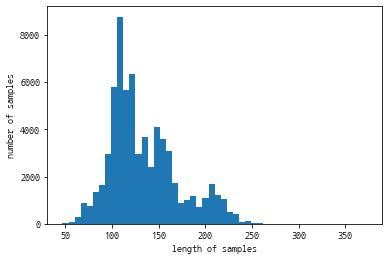

In [32]:
plt.hist([len(s) for s in features], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### train set / test set 분리

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels , test_size=0.2, stratify=labels, random_state=41)
print(len(x_train), len(x_test))

52866 13217


### 전체적인 단어 갯수, 단어 빈도, 희귀 단어 파악 하기 위해 Tokenizing
> Tokenizing 통해서 전체 문장에서 단어 빈도, 단어 개수, 희귀 단어 등을 파악하여 나중에 해당 정로를 이용하여 다시 Tokenizing 할 예정임

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [36]:
print(tokenizer.word_index)

{'server': 1, 'platform': 2, 'service': 3, 'critical': 4, 'sdsc': 5, 'seolleung': 6, 'memory': 7, 'fatal': 8, 'etc': 9, 'usage': 10, 'check': 11, 'cheonan': 12, 'more': 13, 'kos': 14, 'rate': 15, 'disk': 16, 'capacity': 17, 'remaining': 18, 'process': 19, 'is': 20, 'as': 21, 'free': 22, 'defined': 23, 'cached': 24, 'buffers': 25, '90': 26, 'for': 27, 'or': 28, 'management': 29, '2': 30, 'ping': 31, '1': 32, 'in': 33, 'vm': 34, 'than': 35, 'pk1': 36, 'log': 37, 'shared': 38, 'cpu': 39, 'impossible': 40, 'mokdong': 41, 'utilization': 42, 'agent': 43, 'it': 44, '19': 45, '95': 46, 'os': 47, 'this': 48, 'down': 49, 'kt': 50, 'authentication': 51, 'ito': 52, 'network': 53, 'old': 54, 'with': 55, 'data': 56, 'collaboration': 57, 'infrastructure': 58, 'could': 59, 'be': 60, 'availability': 61, 'icmp': 62, 'always': 63, 'returns': 64, 'item': 65, 'used': 66, 'combination': 67, 'nodata': 68, 'l2': 69, 'port': 70, 'integrated': 71, 'fare': 72, 'security': 73, 'monitoring': 74, 'comm': 75, 'syste

In [37]:
print(tokenizer.index_word)

{1: 'server', 2: 'platform', 3: 'service', 4: 'critical', 5: 'sdsc', 6: 'seolleung', 7: 'memory', 8: 'fatal', 9: 'etc', 10: 'usage', 11: 'check', 12: 'cheonan', 13: 'more', 14: 'kos', 15: 'rate', 16: 'disk', 17: 'capacity', 18: 'remaining', 19: 'process', 20: 'is', 21: 'as', 22: 'free', 23: 'defined', 24: 'cached', 25: 'buffers', 26: '90', 27: 'for', 28: 'or', 29: 'management', 30: '2', 31: 'ping', 32: '1', 33: 'in', 34: 'vm', 35: 'than', 36: 'pk1', 37: 'log', 38: 'shared', 39: 'cpu', 40: 'impossible', 41: 'mokdong', 42: 'utilization', 43: 'agent', 44: 'it', 45: '19', 46: '95', 47: 'os', 48: 'this', 49: 'down', 50: 'kt', 51: 'authentication', 52: 'ito', 53: 'network', 54: 'old', 55: 'with', 56: 'data', 57: 'collaboration', 58: 'infrastructure', 59: 'could', 60: 'be', 61: 'availability', 62: 'icmp', 63: 'always', 64: 'returns', 65: 'item', 66: 'used', 67: 'combination', 68: 'nodata', 69: 'l2', 70: 'port', 71: 'integrated', 72: 'fare', 73: 'security', 74: 'monitoring', 75: 'comm', 76: 's

In [38]:
# 단어 갯수 : 24091
len(tokenizer.index_word)

24091

### 전체중에 희귀단어 건수 확인

In [39]:
# 희귀 단어가 50% 이상을 차지하지만, 전체중에 빈도 비율이 1~2% 매우 낮다. 휘귀 단어 토톤화에서 제거할수 있다.
threshold = 3
total_cnt = len(tokenizer.word_index)    # 단어의 수
rare_cnt = 0       # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0     # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0      # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24091
등장 빈도가 2번 이하인 희귀 단어의 수: 16147
단어 집합에서 희귀 단어의 비율: 67.02503009422605
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9203807807878077


In [40]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2

print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 7946


### 위의 정보를 바탕으로 다시 Tokenizer 하자
> max_words : 7946 (단어 빈도 3이상 단어 갯수)

In [41]:
max_words = vocab_size ## 단어 빈도수가 3이상 단어 갯수

In [42]:
# max_words만큼의 단어만 토콘화함
tokenizer = Tokenizer(num_words=max_words, oov_token = 'OOV')   
tokenizer.fit_on_texts(x_train)

In [43]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [44]:
print(len(x_train_seq), len(x_test_seq))

52866 13217


In [45]:
print(x_test_seq[:2])

[[9, 2, 7, 6, 8, 11, 16, 47, 14, 36, 262, 163, 589, 52, 3, 1, 8, 21, 24, 22, 23, 25, 26, 8], [5, 2, 13, 179, 36, 241, 23, 34, 247, 283, 295, 39, 4, 4933, 259, 37, 326]]


### 문장의 Max Len를 찾아보자

In [46]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [47]:
# max_len 값을 변경하면서 샘플 비율 확인하자
max_len = 35
below_threshold_len(max_len, x_train_seq)

전체 샘플 중 길이가 35 이하인 샘플의 비율: 98.40729391291188


### Padding Sequence

In [48]:
max_len = 35 ## 문장 최대 길이

In [49]:
x_train_pad = pad_sequences(x_train_seq, maxlen = max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen = max_len)

In [50]:
x_train_pad[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    5,    2,  110,   42,
         309,  192,   12,    4,    3, 3598,   30,  102,  175, 1877,    1,
         192,   12]], dtype=int32)

In [51]:
x_train_pad.shape, x_test_pad.shape

((52866, 35), (13217, 35))

### 모델링

In [52]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPool2D
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, SimpleRNN, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
embedding_dim = 128 ## 단어 embedding 차원

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len ))

model.add(Conv1D(32, 5, activation='swish'))
model.add(LSTM(16, return_sequences=True))
model.add(GRU(16, return_sequences=True))
model.add(Flatten())
model.add(Dense(128, activation='swish'))
model.add(Dense(32, activation='swish'))
model.add(Dense(3, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 35, 128)           1017088   
_________________________________________________________________
conv1d (Conv1D)              (None, 31, 32)            20512     
_________________________________________________________________
lstm (LSTM)                  (None, 31, 16)            3136      
_________________________________________________________________
gru (GRU)                    (None, 31, 16)            1632      
_________________________________________________________________
flatten (Flatten)            (None, 496)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               63616     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [54]:
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1)

In [55]:
%%time
history = model.fit(x_train_pad, y_train, epochs=50, batch_size=512, 
                      validation_split=0.2, verbose =1, callbacks=[es])

Epoch 1/50
83/83 [==============================] - 24s 293ms/step - loss: 0.6660 - accuracy: 0.7172 - val_loss: 0.4717 - val_accuracy: 0.8224
Epoch 2/50
83/83 [==============================] - 20s 238ms/step - loss: 0.4029 - accuracy: 0.8481 - val_loss: 0.4202 - val_accuracy: 0.8442
Epoch 3/50
83/83 [==============================] - 20s 240ms/step - loss: 0.3506 - accuracy: 0.8705 - val_loss: 0.3989 - val_accuracy: 0.8556
Epoch 4/50
83/83 [==============================] - 20s 242ms/step - loss: 0.3189 - accuracy: 0.8813 - val_loss: 0.3954 - val_accuracy: 0.8573
Epoch 5/50
83/83 [==============================] - 20s 241ms/step - loss: 0.2949 - accuracy: 0.8900 - val_loss: 0.3983 - val_accuracy: 0.8610
Epoch 6/50
83/83 [==============================] - 20s 239ms/step - loss: 0.2787 - accuracy: 0.8944 - val_loss: 0.4084 - val_accuracy: 0.8602
Epoch 7/50
83/83 [==============================] - 20s 236ms/step - loss: 0.2640 - accuracy: 0.8987 - val_loss: 0.4107 - val_accuracy: 0.8590

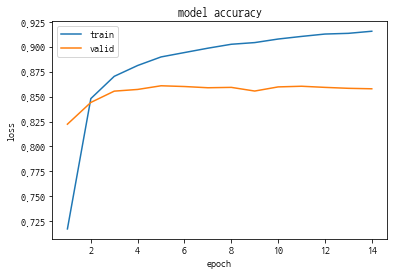

In [56]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], )
plt.show()

In [57]:
model.evaluate(x_test_pad, y_test)

414/414 [==============================] - 4s 10ms/step - loss: 0.4949 - accuracy: 0.8567


[0.4949299097061157, 0.8566997051239014]

### 예측해 보기

In [58]:
print(f'문자열 : {x_test[0]}')
print(f'Sequence : {x_test_pad[:1]}')

문자열 : fatal server seolleung sdsc memory usage rate 95 more than residual 4.56 authentication platform silk02silk01osavailable memory is defined as free+cached+buffers memory.
Sequence : [[  0   0   0   0   0   0   0   0   0   0   0   9   2   7   6   8  11  16
   47  14  36 262 163 589  52   3   1   8  21  24  22  23  25  26   8]]


In [59]:
predict = model.predict(x_test_pad[:1])

In [60]:
print(f'True : {class2label[y_test[0]]}')
print(f'Predict : {class2label[np.argmax(predict)]}')

True :  No action 
Predict :  No action 
